In [1]:
import pydra

import matplotlib.pyplot as plt
import sklearn

In [2]:
# load data
!pip install sklearn
!pip install matplotlib

# Machine Learning Workflow

Hyperparameter tuning is an important step in developing machine learning models.  
XXX You learned how to run multiple tasks within a pipeline with *pydra* `Workflow` in the `intro_workflow` tutorial.  


Let's initiate a `Workflow` with **MNIST** data as input: 

In [3]:
from sklearn import datasets

digits = datasets.load_digits(n_class=10, return_X_y=False)

In [13]:
digits.images[1]

array([[ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16.,  9.,  0.,  0.],
       [ 0.,  0.,  3., 15., 16.,  6.,  0.,  0.],
       [ 0.,  7., 15., 16., 16.,  2.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  3.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16., 10.,  0.,  0.]])

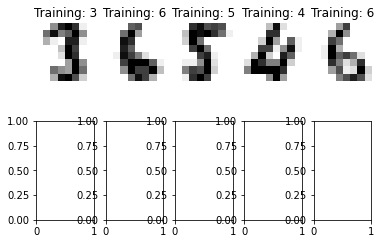

In [11]:
import random
random.seed(10)

_, axes = plt.subplots(2, 5)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], random.sample(images_and_labels, 5)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)


In [14]:
## Support Vector Machine

Let's build a workflow with one model only to start.  Here we use SVM (Support Vector Machine) for classification

## Define `FunctionTask`

In [ ]:
# 


In [101]:
import typing as ty

# https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
# linear SVM
@pydra.mark.task
#@pydra.mark.annotate({"return": {"clf": ty.Any}})
def fit_SVM(X_tr, y_tr, C=1, kernel='rbf', gamma=1):
    from sklearn.svm import SVC
    clf = SVC(C=C, kernel=kernel, gamma=gamma)
    clf.fit(X_tr, y_tr)
    return(404)

# metrics
@pydra.mark.task
#@pydra.mark.annotate({"return": {"score": ty.Any}})
def metric_score(clf, X_tt, y_tt, metric):
    
    y_pred = clf.predict(X_tt)
    
    from sklearn import metrics
    if metric == 'accuracy':
        score = metrics.accuracy_score(y_tt, y_pred)
    elif metric == 'precision':
        score = metrics.precision_score(y_tt, y_pred)
    else:
        score = metrics.recall_score(y_tt, y_pred)
    return(score)
    

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

data[1]

clf = SVC()
clf.fit(X_train, y_train)

print(clf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [100]:
X_test.shape

(899, 64)

# Create workflow

In [38]:
input_grid = {'X_tr': X_train,
              'X_tt': X_test,
              'y_tr': y_train,
              'y_tt': y_test,
              'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001], #'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'poly', 'sigmoid']}

In [102]:
# for fit_SVM
input_grid = {'X_tr': X_train,
              #'X_tt': X_test,
              'y_tr': y_train,
              #'y_tt': y_test,
              'C': 1, 
              'gamma': [1,0.1,0.01,0.001], #'gamma': ['scale', 'auto'],
              'kernel': 'rbf',
              'metric': ['accuracy', 'precision', 'recall']}

# for metrics
#metric_list = ['accuracy', 'precision', 'recall']

In [104]:
wf1 = pydra.Workflow(name="svm1", 
                     input_spec=list(input_grid.keys()), **input_grid)
wf1.split('gamma')
wf1.add(fit_SVM(name='svm', **input_grid))
wf1.set_output([("out", wf1.svm.lzout.out)])

#wf1.add(metric_score(name='metric', clf=wf1.svm.lzout.out,
#                     X_tt=wf1.lzin.X_tt, y_tt=wf1.lzin.y_tt, metric=wf1.lzin.metric))

#wf1.set_output([("clf", wf1.svm.lzout.out),
#                ("score", wf1.metric.lzout.out)
#               ])


#with pydra.Submitter(plugin="cf") as sub:
#    sub(wf1)

wf1.result()

In [85]:
wf1 = pydra.Workflow(name="svm1", 
                     input_spec=list(input_grid.keys()), **input_grid)

In [86]:
wf1